# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка данных

In [1]:
import pandas as pd
from sklearn.preprocessing import OrdinalEncoder
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
from catboost import Pool, CatBoostRegressor, cv
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error
import numpy as np

Подготовка данных

Откроем файлы и изучим их

In [2]:
auto_df = pd.read_csv('/datasets/autos.csv')

In [3]:
display(auto_df.head(10))
print(auto_df.info())
print('Количество дубликатов:', sum(auto_df.duplicated()))

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21
5,2016-04-04 17:36:23,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,2016-04-04 00:00:00,0,33775,2016-04-06 19:17:07
6,2016-04-01 20:48:51,2200,convertible,2004,manual,109,2_reihe,150000,8,petrol,peugeot,no,2016-04-01 00:00:00,0,67112,2016-04-05 18:18:39
7,2016-03-21 18:54:38,0,sedan,1980,manual,50,other,40000,7,petrol,volkswagen,no,2016-03-21 00:00:00,0,19348,2016-03-25 16:47:58
8,2016-04-04 23:42:13,14500,bus,2014,manual,125,c_max,30000,8,petrol,ford,NaN,2016-04-04 00:00:00,0,94505,2016-04-04 23:42:13
9,2016-03-17 10:53:50,999,small,1998,manual,101,golf,150000,0,NaN,volkswagen,NaN,2016-03-17 00:00:00,0,27472,2016-03-31 17:17:06


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [4]:
print('Количество пропусков', 
      auto_df.isna().mean())


Количество пропусков DateCrawled          0.000000
Price                0.000000
VehicleType          0.105794
RegistrationYear     0.000000
Gearbox              0.055967
Power                0.000000
Model                0.055606
Kilometer            0.000000
RegistrationMonth    0.000000
FuelType             0.092827
Brand                0.000000
Repaired             0.200791
DateCreated          0.000000
NumberOfPictures     0.000000
PostalCode           0.000000
LastSeen             0.000000
dtype: float64


In [5]:
auto_df.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


Выводы

1. В столбце Цена минимальная цена 0.
2. В столбце RegistrationYear есть некорректные значения года регистрации.
3. В столбце Power есть некорректные значения мощности двигателя.
4. В столбце Kilometer более 50% с пробегом 150000 при этом ни боьше ни меньше, скорее всего это какое-то ограничение в заявке, но согласитесь разница между 150000 и 300000 довольно существена и даолжна влиять на стоимость.
5. В столбце RegistrationMonth отсутсвует месяц регистрации.


Далее пройдемся по признакам, значимых для нашей модели:

-VehicleType. Тип машины определяет ее функционал и возможности. Чем их больше машины, тем выше цена.

-RegistrationYear. Год регистрации определяет "свежесть" машины. Соответвенно, чем больше возраст, тем меньше цена.

-Gearbox. Наличие автоматической коробки передач повышает стоимость машины из-за сложности конструкции.

-Power. Мощность в лошадиных силах напрямую влияют на цену.

-Model. В совокупности с типом машины и брендом може влиять на популярность у покупателей.

-Kilometer. Чем больше пробег, тем меньше ее надежность и соответсвенно цена.

-FuelType. Тип топлива определяет конструкцию двигателя внутреннего сгорания.

-Brand. Концерн/компания, которая создала автомобиль показывает качество и надежность автомобиля.

-Repaired. Если машина побывала в ДТП, то ее констукция уже видиизменена, следовательно надежность и качество ниже, как и цена.

In [6]:
# На основе вывода создадим новый фрейм
filtred_auto_df = auto_df[['VehicleType', 
                         'RegistrationYear',
                         'Gearbox', 
                         'Power',
                         'Model',
                         'Kilometer',
                         'FuelType',
                         'Brand',
                         'Repaired',
                         'Price']]
filtred_auto_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   VehicleType       316879 non-null  object
 1   RegistrationYear  354369 non-null  int64 
 2   Gearbox           334536 non-null  object
 3   Power             354369 non-null  int64 
 4   Model             334664 non-null  object
 5   Kilometer         354369 non-null  int64 
 6   FuelType          321474 non-null  object
 7   Brand             354369 non-null  object
 8   Repaired          283215 non-null  object
 9   Price             354369 non-null  int64 
dtypes: int64(4), object(6)
memory usage: 27.0+ MB


In [7]:
filtred_auto_df.duplicated().sum()

45040

In [8]:
filtred_auto_df = filtred_auto_df.drop_duplicates()
filtred_auto_df.duplicated().sum()

0

Типы данных в столбцах верные, однако мы видим, что пропуском довольно много, следовательно:

1. В столбце VehicleType постараемся восстановить данные на основе популярного показателя из столбца Brand

2. В столбце RegistrationYear скоректируем данные на основе реальных значений в машинах в сравнении с другими (пробег, марка, модель)

3. В столбце Gearbox везде заполнил как manual - ручная

4. В столбце Power скоректируем данные на основе реальных значений по аналогии с RegistrationYear

5. В столбце FuelType по анлогии сVehicleType

6. В столбце Repaired для всех NaN И пропусков установим значение yes

7. В столбце Model для всех NaN установим значение 'unknown'.

Но прежде всего отработаем данные п оцелевому признаку Price

<AxesSubplot:>

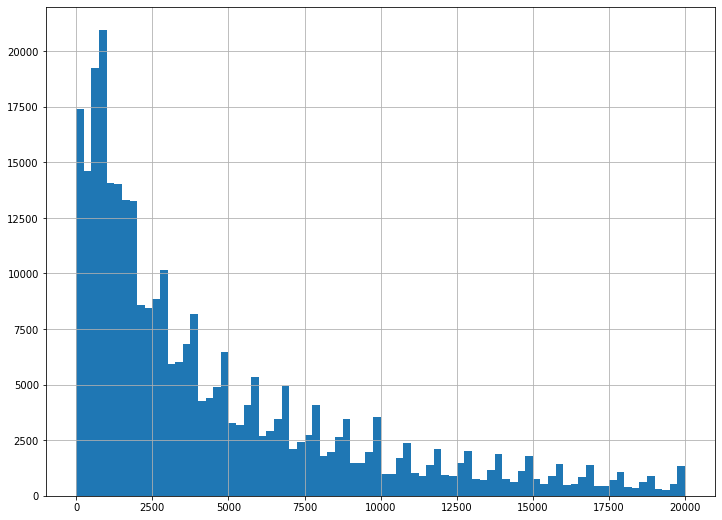

In [9]:
# Построим гистограмму
filtred_auto_df['Price'].hist(bins=80, figsize=(12,9))

In [10]:
filtred_auto_df['Price'].value_counts()

0        8904
500      4650
1500     4533
1000     3875
1200     3799
         ... 
1654        1
5748        1
7285        1
11379       1
8188        1
Name: Price, Length: 3731, dtype: int64

count    300425.000000
mean       4619.921098
std        4565.205287
min           1.000000
25%        1200.000000
50%        2900.000000
75%        6650.000000
max       20000.000000
Name: Price, dtype: float64

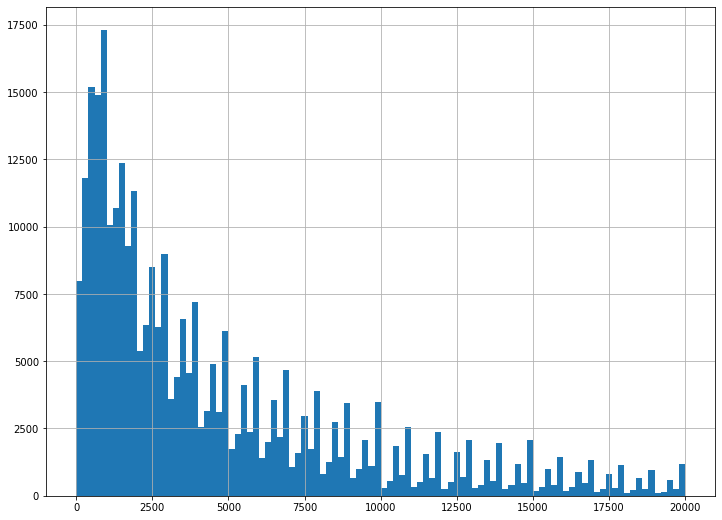

In [11]:
filtred_auto_df = filtred_auto_df.query('Price > 0')
filtred_auto_df['Price'].hist(bins=100, figsize=(12,9))
filtred_auto_df['Price'].describe()

In [12]:
filtred_auto_df['Price'].quantile([0.2, 0.88])

0.20      990.0
0.88    10750.0
Name: Price, dtype: float64

Стоимость 990 евро примерно равно 66000 рублей (в целом за такую сумму можно купить машину). Выбор 88% квантиля обоснован выбросами после 10000 евро и в целом на гистограмме видно, что значения после не особо отличаются.


In [13]:
filtred_auto_df = filtred_auto_df.query('990 <= Price <= 15500')
filtred_auto_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 228598 entries, 2 to 354368
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   VehicleType       209270 non-null  object
 1   RegistrationYear  228598 non-null  int64 
 2   Gearbox           219798 non-null  object
 3   Power             228598 non-null  int64 
 4   Model             217855 non-null  object
 5   Kilometer         228598 non-null  int64 
 6   FuelType          211833 non-null  object
 7   Brand             228598 non-null  object
 8   Repaired          190180 non-null  object
 9   Price             228598 non-null  int64 
dtypes: int64(4), object(6)
memory usage: 19.2+ MB


Далее перейдем в столбцу 'RegistrationYear'

count    228598.000000
mean       2004.486767
std          58.774634
min        1000.000000
25%        2000.000000
50%        2004.000000
75%        2008.000000
max        9999.000000
Name: RegistrationYear, dtype: float64

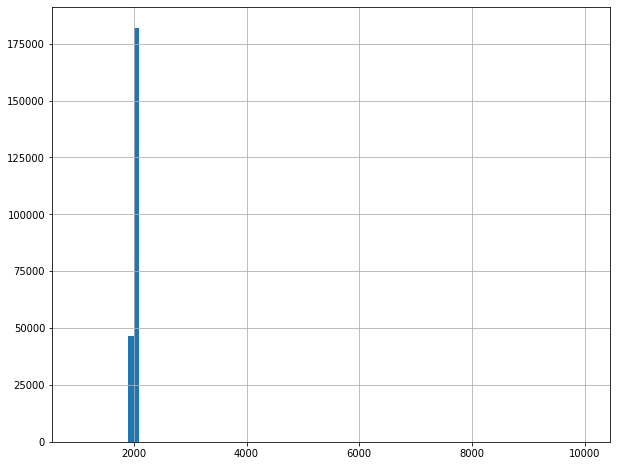

In [14]:
filtred_auto_df['RegistrationYear'].hist(bins=90, figsize=(10,8))
filtred_auto_df['RegistrationYear'].describe()

In [15]:
car_date_max = pd.to_datetime(auto_df['DateCrawled'])
car_date_max.max()

Timestamp('2016-04-07 14:36:58')

In [16]:
car_date_min = pd.to_datetime(auto_df['RegistrationYear'])
car_date_min.min()

Timestamp('1970-01-01 00:00:00.000001')

count    217616.000000
mean       2003.456557
std           6.096802
min        1971.000000
25%        2000.000000
50%        2004.000000
75%        2007.000000
max        2016.000000
Name: RegistrationYear, dtype: float64

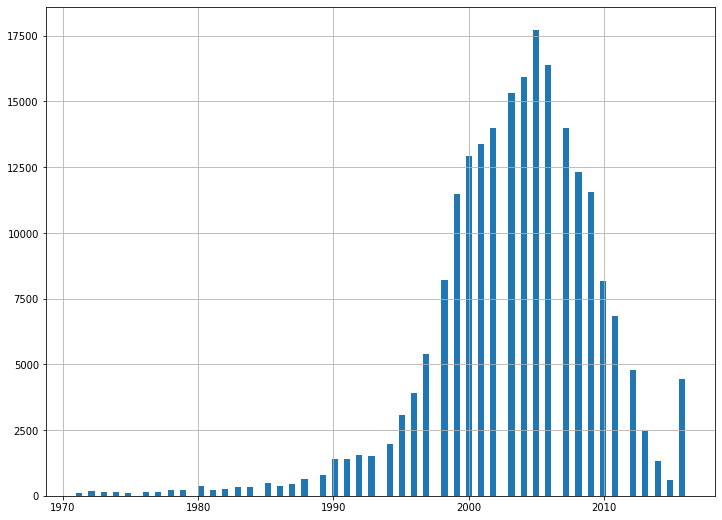

In [17]:
filtred_auto_df = filtred_auto_df.query('1970 < RegistrationYear < 2017')
filtred_auto_df['RegistrationYear'].hist(bins=100, figsize=(12,9))
filtred_auto_df['RegistrationYear'].describe()

Даты регистрации после 2016 года некорректны, как и до 1970. Отсечем ненужные года и построим график, в целом у нас вырисовывается хороший график.


Далее зайемемся заменов данных в столбцах Gearbox, Repaired и Model


In [18]:
filtred_auto_df.fillna({'Gearbox':'manual', 'Repaired':'yes', 'Model':'unknown'},
                          inplace=True)
filtred_auto_df.isna().mean()

VehicleType         0.042396
RegistrationYear    0.000000
Gearbox             0.000000
Power               0.000000
Model               0.000000
Kilometer           0.000000
FuelType            0.058594
Brand               0.000000
Repaired            0.000000
Price               0.000000
dtype: float64

Супер, осталось разобраться со столбцами VehicleType и FuelType

In [19]:
# Оценим кол-во пропущенных значений относительно всех значений в столбце VehicleType, 
# в целом мы бы могли просто закинуть из в другие или в самый популярный тип седан,
# но это было бы не качественно, так что идем дальше
display(filtred_auto_df['VehicleType'].value_counts())
display(filtred_auto_df['VehicleType'].isna().sum())

sedan          60545
small          44789
wagon          43926
bus            22294
convertible    15249
coupe          10827
suv             8584
other           2176
Name: VehicleType, dtype: int64

9226

In [20]:
#Построим сводную таблицу для того чтобы наглядно увидеть у каких марок, какие модели, какой кузов и сколько их.
vehicle_type_pvt = filtred_auto_df.pivot_table(index=['VehicleType'], 
                                                    columns=['Brand'],
                                                    values=['Price'],
                                                    aggfunc=['count'])
display(vehicle_type_pvt)


count                                                     \
                 Price                                                      
Brand       alfa_romeo    audi      bmw chevrolet chrysler citroen  dacia   
VehicleType                                                                 
bus                NaN    10.0      5.0     128.0    276.0  1047.0   46.0   
convertible      148.0  1237.0   2442.0       8.0    179.0   102.0    NaN   
coupe            187.0   937.0   2467.0      63.0     36.0   103.0    NaN   
other              6.0    72.0    149.0      30.0      9.0    78.0    5.0   
sedan            612.0  7176.0  12299.0     185.0    175.0   485.0   89.0   
small            181.0  1063.0    283.0     505.0      8.0  1136.0  196.0   
suv                NaN    50.0    509.0     304.0     18.0    25.0  196.0   
wagon            324.0  7897.0   5726.0      94.0    197.0   416.0  225.0   

                                     ...                          \
                                     ...                           
Brand       daewoo daihatsu    fiat  ...    seat   skoda   smart   
VehicleType                          ...                           
bus           18.0     19.0   651.0  ...   510.0   204.0     1.0   
convertible    NaN     16.0   373.0  ...     NaN     2.0  1018.0   
coupe          1.0      NaN   123.0  ...    54.0     6.0   288.0   
other          3.0      5.0   128.0  ...    36.0    20.0     7.0   
sedan         44.0     32.0   549.0  ...  1279.0   736.0    25.0   
small        139.0    245.0  2890.0  ...  1932.0   898.0  2713.0   
suv            1.0     29.0    22.0  ...     3.0   120.0     NaN   
wagon         19.0     14.0   237.0  ...   243.0  2154.0     1.0   

                                                                             
                                                                             
Brand       sonstige_autos subaru suzuki  toyota trabant volkswagen   volvo  
VehicleType                                                                  
bus                  154.0   13.0   19.0   407.0     NaN     7281.0     NaN  
convertible          214.0    1.0   28.0    59.0    31.0     2073.0    62.0  
coupe                121.0    4.0    2.0   150.0     2.0     1118.0    48.0  
other                140.0    4.0   11.0    15.0     5.0      535.0     2.0  
sedan                276.0  114.0  126.0   749.0    91.0    12384.0   452.0  
small                160.0   52.0  636.0  1287.0    28.0     9747.0     7.0  
suv                  312.0   46.0  654.0   382.0     1.0      788.0   116.0  
wagon                 96.0  184.0   53.0   472.0    40.0     8280.0  1230.0  

[8 rows x 40 columns]

In [21]:
vehicle_type_pvt = vehicle_type_pvt['count']['Price']
vehicle_type_pvt

Brand,alfa_romeo,audi,bmw,chevrolet,chrysler,citroen,dacia,daewoo,daihatsu,fiat,...,seat,skoda,smart,sonstige_autos,subaru,suzuki,toyota,trabant,volkswagen,volvo
VehicleType,,,,,,,,,,,,,,,,,,,,,
bus,NaN,10.0,5.0,128.0,276.0,1047.0,46.0,18.0,19.0,651.0,...,510.0,204.0,1.0,154.0,13.0,19.0,407.0,NaN,7281.0,NaN
convertible,148.0,1237.0,2442.0,8.0,179.0,102.0,NaN,NaN,16.0,373.0,...,NaN,2.0,1018.0,214.0,1.0,28.0,59.0,31.0,2073.0,62.0
coupe,187.0,937.0,2467.0,63.0,36.0,103.0,NaN,1.0,NaN,123.0,...,54.0,6.0,288.0,121.0,4.0,2.0,150.0,2.0,1118.0,48.0
other,6.0,72.0,149.0,30.0,9.0,78.0,5.0,3.0,5.0,128.0,...,36.0,20.0,7.0,140.0,4.0,11.0,15.0,5.0,535.0,2.0
sedan,612.0,7176.0,12299.0,185.0,175.0,485.0,89.0,44.0,32.0,549.0,...,1279.0,736.0,25.0,276.0,114.0,126.0,749.0,91.0,12384.0,452.0
small,181.0,1063.0,283.0,505.0,8.0,1136.0,196.0,139.0,245.0,2890.0,...,1932.0,898.0,2713.0,160.0,52.0,636.0,1287.0,28.0,9747.0,7.0
suv,NaN,50.0,509.0,304.0,18.0,25.0,196.0,1.0,29.0,22.0,...,3.0,120.0,NaN,312.0,46.0,654.0,382.0,1.0,788.0,116.0
wagon,324.0,7897.0,5726.0,94.0,197.0,416.0,225.0,19.0,14.0,237.0,...,243.0,2154.0,1.0,96.0,184.0,53.0,472.0,40.0,8280.0,1230.0


In [22]:
# Заполним пустые ячейки 0
filtred_auto_df.fillna({'VehicleType':0},inplace=True)
# Напишем функцию которая будет в пропущенные значения вставлять тот тип кузова, который 
# чаще всего распрастранен для конкретной марки марки авто
def fillna_by_brand(row, row_number, vehicle_type_pvt):
    brand = row[7]
    fill_value = row[row_number]
    if row[row_number] == 0:
        fill_value = vehicle_type_pvt[brand].idxmax()
    return fill_value
# Применим функцию
filtred_auto_df['VehicleType'] = filtred_auto_df.apply(
                                fillna_by_brand, 
                                args=[0, vehicle_type_pvt],
                                axis=1)
display(filtred_auto_df['VehicleType'].isna().sum())
filtred_auto_df['VehicleType'].value_counts()

0

sedan          65082
small          48198
wagon          44876
bus            22335
convertible    15267
coupe          10827
suv             8855
other           2176
Name: VehicleType, dtype: int64

Супер, по аналогии сделаем для столбца FuelType

In [23]:
filtred_auto_df['FuelType'].value_counts()
fuel_type_pvt = filtred_auto_df.pivot_table(index=['FuelType'], 
                                                          columns=['Brand'],
                                                          values=['Price'],
                                                          aggfunc=['count'])
fuel_type_pvt = fuel_type_pvt['count']['Price']
display(fuel_type_pvt)

filtred_auto_df.fillna({'FuelType':0},inplace=True)

filtred_auto_df['FuelType'] = filtred_auto_df.apply(
                                fillna_by_brand, 
                                args=[4, vehicle_type_pvt],
                                axis=1)
display(filtred_auto_df['FuelType'].isna().sum())
filtred_auto_df['FuelType'].value_counts()


Brand,alfa_romeo,audi,bmw,chevrolet,chrysler,citroen,dacia,daewoo,daihatsu,fiat,...,seat,skoda,smart,sonstige_autos,subaru,suzuki,toyota,trabant,volkswagen,volvo
FuelType,,,,,,,,,,,,,,,,,,,,,
cng,NaN,1.0,8.0,4.0,NaN,6.0,2.0,NaN,NaN,58.0,...,1.0,6.0,2.0,4.0,1.0,NaN,NaN,NaN,153.0,16.0
electric,NaN,1.0,3.0,NaN,NaN,1.0,NaN,NaN,1.0,3.0,...,NaN,NaN,3.0,19.0,NaN,NaN,NaN,NaN,1.0,NaN
gasoline,462.0,8484.0,8308.0,193.0,308.0,1266.0,194.0,1.0,3.0,1127.0,...,1273.0,1516.0,745.0,378.0,33.0,192.0,848.0,1.0,17710.0,748.0
hybrid,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,...,1.0,NaN,1.0,14.0,NaN,NaN,88.0,NaN,3.0,NaN
lpg,23.0,372.0,607.0,150.0,72.0,56.0,46.0,18.0,3.0,57.0,...,46.0,44.0,2.0,85.0,24.0,15.0,17.0,NaN,385.0,77.0
other,NaN,1.0,5.0,NaN,NaN,1.0,NaN,NaN,NaN,1.0,...,NaN,NaN,1.0,8.0,NaN,1.0,NaN,19.0,12.0,1.0
petrol,955.0,9267.0,14315.0,943.0,502.0,2020.0,493.0,204.0,347.0,3689.0,...,2714.0,2505.0,3270.0,895.0,342.0,1296.0,2541.0,144.0,23507.0,1033.0


0

golf                  16266
other                 15785
3er                   13010
unknown                9108
a4                     6489
                      ...  
gl                        2
serie_3                   2
elefantino                2
serie_1                   1
range_rover_evoque        1
Name: FuelType, Length: 251, dtype: int64

In [24]:
filtred_auto_df.isna().mean()

VehicleType         0.0
RegistrationYear    0.0
Gearbox             0.0
Power               0.0
Model               0.0
Kilometer           0.0
FuelType            0.0
Brand               0.0
Repaired            0.0
Price               0.0
dtype: float64

Далее займемся столбцом Power


count    217616.000000
mean        119.481789
std         199.953433
min           0.000000
25%          75.000000
50%         113.000000
75%         150.000000
max       20000.000000
Name: Power, dtype: float64

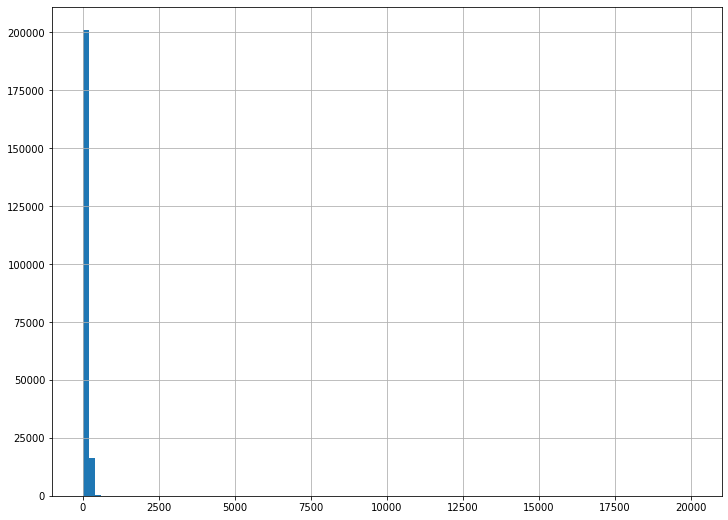

In [25]:
filtred_auto_df['Power'].hist(bins=100, figsize=(12,9))
filtred_auto_df['Power'].describe()

count    217431.000000
mean        115.856870
std          60.433162
min           0.000000
25%          75.000000
50%         113.000000
75%         150.000000
max        1000.000000
Name: Power, dtype: float64

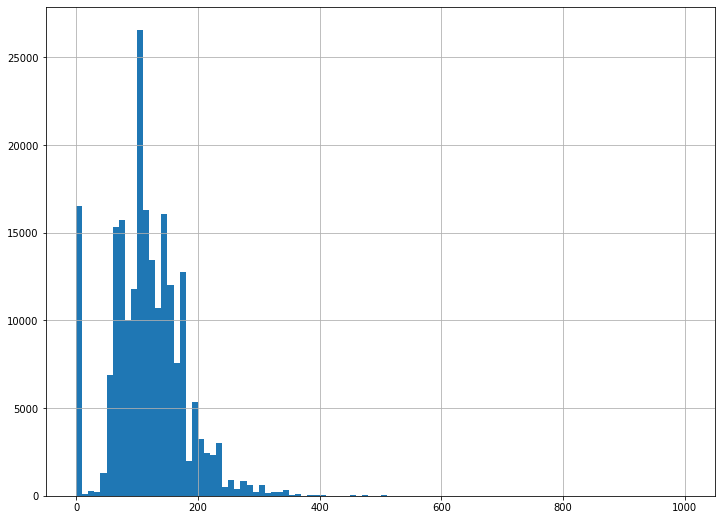

In [26]:
filtred_auto_df = filtred_auto_df.query('Power < 1001')
filtred_auto_df['Power'].hist(bins=100, figsize=(12,9))
filtred_auto_df['Power'].describe()


Из данных и графика видно, что многие машины имеют мощность 0, уберем их

count    200936.000000
mean        124.989942
std          51.236650
min           1.000000
25%          90.000000
50%         116.000000
75%         150.000000
max         449.000000
Name: Power, dtype: float64

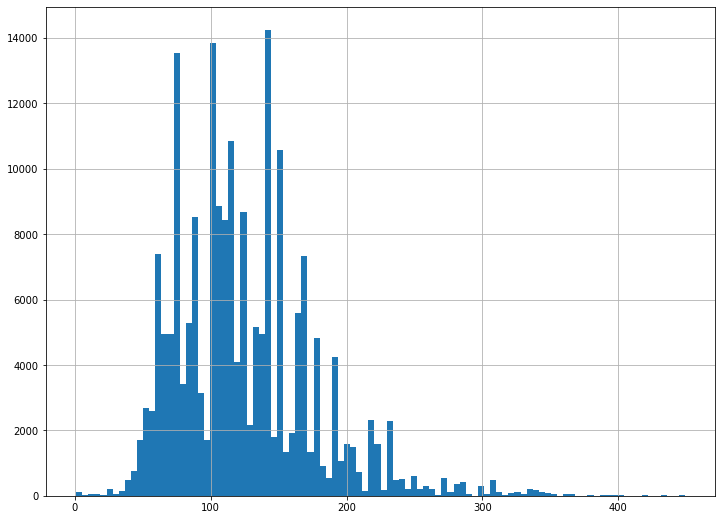

In [27]:
# Справа подобрали значение в 450 л.с.
filtred_auto_df = filtred_auto_df.query('0 < Power < 450')
filtred_auto_df['Power'].hist(bins=100, figsize=(12,9))
filtred_auto_df['Power'].describe()

In [28]:
good_auto_df = filtred_auto_df
good_auto_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 200936 entries, 2 to 354368
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   VehicleType       200936 non-null  object
 1   RegistrationYear  200936 non-null  int64 
 2   Gearbox           200936 non-null  object
 3   Power             200936 non-null  int64 
 4   Model             200936 non-null  object
 5   Kilometer         200936 non-null  int64 
 6   FuelType          200936 non-null  object
 7   Brand             200936 non-null  object
 8   Repaired          200936 non-null  object
 9   Price             200936 non-null  int64 
dtypes: int64(4), object(6)
memory usage: 16.9+ MB


Далее нам нужно привести данные столбцов Gearbox и NotRepaire в булевый тип, чтобы было легче работать программе и быстрее все обрабатывать.

In [29]:
# Создадим столбец 'Is_manual_gearbox', где 1 - это manual, 0 - это auto
good_auto_df['Is_manual_gearbox'] = 0
good_auto_df.loc[good_auto_df['Gearbox'] == 'manual', 'Is_manual_gearbox'] = 1
display(good_auto_df['Is_manual_gearbox'].value_counts())
good_auto_df['Gearbox'].value_counts()

1    157939
0     42997
Name: Is_manual_gearbox, dtype: int64

manual    157939
auto       42997
Name: Gearbox, dtype: int64

In [30]:
# Создадим столбец 'Was_not_repaired', где 1 - это машина не ремонтировалась, 0 - машина с ремонтом
good_auto_df['Was_not_repaired'] = 0
good_auto_df.loc[good_auto_df['Repaired'] == 'yes', 'Was_not_repaired'] = 1
display(good_auto_df['Was_not_repaired'].value_counts())
good_auto_df['Repaired'].value_counts()

0    160064
1     40872
Name: Was_not_repaired, dtype: int64

no     160064
yes     40872
Name: Repaired, dtype: int64

Приведем датафрейм в порядок, удалим уже не нужные столбцы, применим также downcast, чтобу уменьшить потребление памяти и ускорить работу фрейма

In [31]:
good_auto_df.drop(['Repaired','Gearbox'], inplace=True, axis=1)
good_auto_df['Was_not_repaired'] = pd.to_numeric(good_auto_df['Was_not_repaired'], downcast='integer')
good_auto_df['Is_manual_gearbox'] = pd.to_numeric(good_auto_df['Is_manual_gearbox'], downcast='integer')
good_auto_df['RegistrationYear'] = pd.to_numeric(good_auto_df['RegistrationYear'], downcast='integer')
good_auto_df['Power'] = pd.to_numeric(good_auto_df['Power'], downcast='integer')
good_auto_df['Kilometer'] = pd.to_numeric(good_auto_df['Kilometer'], downcast='integer')
good_auto_df['Price'] = pd.to_numeric(good_auto_df['Price'], downcast='integer')
good_auto_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 200936 entries, 2 to 354368
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   VehicleType        200936 non-null  object
 1   RegistrationYear   200936 non-null  int16 
 2   Power              200936 non-null  int16 
 3   Model              200936 non-null  object
 4   Kilometer          200936 non-null  int32 
 5   FuelType           200936 non-null  object
 6   Brand              200936 non-null  object
 7   Price              200936 non-null  int16 
 8   Is_manual_gearbox  200936 non-null  int8  
 9   Was_not_repaired   200936 non-null  int8  
dtypes: int16(3), int32(1), int8(2), object(4)
memory usage: 10.0+ MB


In [32]:
print('Уменьшение использования памяти на {:.2%}'.format(1 - 10.2/43.3))

Уменьшение использования памяти на 76.44%


Вывод

1. Были проанализированы данные

2. Обработаны пропуски,аномалии и некорректные значения

3. Выбраны необходимые столбцы для обучения модели

4. Заменены категориальные признаки данных на численые

5. Обработали датафрейм и в итоге уменьшили потребление памяти на 76%

## Обучение моделей

Подготовим три типа признаков для кроссвалидации:

-Неизмененные. Название original_features.
-Закодированные методом OHE. Название ohe_features.
-Закодированные методом OE. Название ordinal_features.

In [33]:
# Неизмененные принаки
original_features = good_auto_df.drop('Price', axis=1)

# Прямое кодирование
encoder = OrdinalEncoder()
cat_columns = ['VehicleType','FuelType','Brand','Model']
cat_features = original_features[cat_columns]
cat_features = pd.DataFrame(encoder.fit_transform(cat_features),
                                columns=cat_features.columns, 
                                index=cat_features.index)
ordinal_features = original_features.copy()
for column in cat_columns:
    ordinal_features[column] = cat_features[column]

#OHE кодирование
ohe_features = pd.get_dummies(original_features, drop_first=True)

#Целевой признак
target = good_auto_df['Price']

In [34]:
#Обуч и тест выборка
original_features_train, original_features_test, target_train, target_test = train_test_split(
    original_features, target, test_size=0.25, random_state=1515)

ordinal_features_train = ordinal_features.loc[original_features_train.index, :]
ordinal_features_test = ordinal_features.loc[original_features_test.index, :]

ohe_features_train = ohe_features.loc[original_features_train.index, :]
ohe_features_test = ohe_features.loc[original_features_test.index, :]

Линейная регрессия

In [35]:
%%time

regressor = LinearRegression()
print('# Train for root_mean_squared_error')
print()
cv_RMSE_LR = (cross_val_score(regressor, 
                             ohe_features_train, 
                             target_train, 
                             cv=5, 
                             scoring='neg_mean_squared_error').mean() * -1) ** 0.5
print('Mean RMSE from CV of LinearRegression =', cv_RMSE_LR)

# Train for root_mean_squared_error

Mean RMSE from CV of LinearRegression = 2298.217507220066
CPU times: user 1min 2s, sys: 36 s, total: 1min 38s
Wall time: 1min 38s


In [36]:
%%time

# Попробуем с масштабируемыми признаками
regressor = LinearRegression()
scaller = StandardScaler()
pipeline = Pipeline([("standard_scaller", scaller),("linear_regression", regressor)])
print('# Train for root_mean_squared_error')
print()
cv_RMSE_LR_S = (cross_val_score(pipeline,
                                ohe_features_train, 
                                target_train, 
                                cv=5, 
                                scoring='neg_mean_squared_error').mean() * -1) ** 0.5
print('Mean RMSE from CV of LinearRegression =', cv_RMSE_LR_S)

# Train for root_mean_squared_error

Mean RMSE from CV of LinearRegression = 35095594236036.59
CPU times: user 1min 8s, sys: 37.1 s, total: 1min 45s
Wall time: 1min 45s


In [37]:
%%time

# Попробуем с масштабируемыми признаками
regressor = LinearRegression()
scaller = RobustScaler()
pipeline = Pipeline([("robust_scaller", scaller),("linear_regression", regressor)])
print('# Train for root_mean_squared_error')
print()
cv_RMSE_LR_S = (cross_val_score(pipeline,
                                ohe_features_train, 
                                target_train, 
                                cv=5, 
                                scoring='neg_mean_squared_error').mean() * -1) ** 0.5
print('Mean RMSE from CV of LinearRegression =', cv_RMSE_LR_S)

# Train for root_mean_squared_error

Mean RMSE from CV of LinearRegression = 683231433.6867783
CPU times: user 1min 7s, sys: 37 s, total: 1min 44s
Wall time: 1min 45s


Вывод: Масштабмрование ухудшает модель

DecissionTree регрессия

In [38]:
%%time

# Модель на признаках, закодированных по методу OHE


regressor = DecisionTreeRegressor() 
max_depth_list = [x for x in range(2, 10)]
hyperparams = [{'criterion':['mse'], 
                'max_depth':max_depth_list, 
                'random_state':[1515]}]

print('# Tuning hyper-parameters for root_mean_squared_error')
print()
clf = GridSearchCV(regressor, hyperparams, scoring='neg_mean_squared_error')
clf.fit(ohe_features_train, target_train)
print("Best parameters set found on development set:")
print()
print(clf.best_params_)
print()
print("Grid scores on development set:")
print()
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.6f for %r"% ((mean*-1)** 0.5, params))
print()

cv_RMSE_DTR_ohe = (max(means)*-1) ** 0.5

# Tuning hyper-parameters for root_mean_squared_error

Best parameters set found on development set:

{'criterion': 'mse', 'max_depth': 9, 'random_state': 1515}

Grid scores on development set:

2744.289409 for {'criterion': 'mse', 'max_depth': 2, 'random_state': 1515}
2533.543853 for {'criterion': 'mse', 'max_depth': 3, 'random_state': 1515}
2296.959498 for {'criterion': 'mse', 'max_depth': 4, 'random_state': 1515}
2149.633590 for {'criterion': 'mse', 'max_depth': 5, 'random_state': 1515}
2037.117961 for {'criterion': 'mse', 'max_depth': 6, 'random_state': 1515}
1963.971521 for {'criterion': 'mse', 'max_depth': 7, 'random_state': 1515}
1895.312835 for {'criterion': 'mse', 'max_depth': 8, 'random_state': 1515}
1842.705411 for {'criterion': 'mse', 'max_depth': 9, 'random_state': 1515}

CPU times: user 1min 20s, sys: 6.24 s, total: 1min 27s
Wall time: 1min 27s


In [39]:
%%time

# Модель на признаках, закодированных по методу OE


regressor = DecisionTreeRegressor() 
max_depth_list = [x for x in range(2, 10)]
hyperparams = [{'criterion':['mse'], 
                'max_depth':max_depth_list, 
                'random_state':[1515]}]

print('# Tuning hyper-parameters for root_mean_squared_error')
print()
clf = GridSearchCV(regressor, hyperparams, scoring='neg_mean_squared_error')
clf.fit(ordinal_features_train, target_train)
print("Best parameters set found on development set:")
print()
print(clf.best_params_)
print()
print("Grid scores on development set:")
print()
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.6f for %r"% ((mean*-1)** 0.5, params))
print()

cv_RMSE_DTR_ordinal = (max(means)*-1) ** 0.5

# Tuning hyper-parameters for root_mean_squared_error

Best parameters set found on development set:

{'criterion': 'mse', 'max_depth': 9, 'random_state': 1515}

Grid scores on development set:

2744.289409 for {'criterion': 'mse', 'max_depth': 2, 'random_state': 1515}
2533.543853 for {'criterion': 'mse', 'max_depth': 3, 'random_state': 1515}
2294.464904 for {'criterion': 'mse', 'max_depth': 4, 'random_state': 1515}
2149.805437 for {'criterion': 'mse', 'max_depth': 5, 'random_state': 1515}
2041.354074 for {'criterion': 'mse', 'max_depth': 6, 'random_state': 1515}
1966.923615 for {'criterion': 'mse', 'max_depth': 7, 'random_state': 1515}
1893.410733 for {'criterion': 'mse', 'max_depth': 8, 'random_state': 1515}
1843.324031 for {'criterion': 'mse', 'max_depth': 9, 'random_state': 1515}

CPU times: user 5.48 s, sys: 0 ns, total: 5.48 s
Wall time: 5.49 s


Регрессия CatBoostRegressor

In [40]:
%%time

# Модель на данных, закодированных по методу OE

regressor = CatBoostRegressor() 
hyperparams = [{'learning_rate':[0.1, 0.5, 0.8],
                'random_state':[1515],
                'verbose':[False]}]

print('# Tuning hyper-parameters for root_mean_squared_error')
print()
clf = GridSearchCV(regressor, hyperparams, scoring='neg_mean_squared_error')
clf.fit(ordinal_features_train, target_train)
print("Best parameters set found on development set:")
print()
print(clf.best_params_)
print()
print("Grid scores on development set:")
print()
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.6f for %r"% ((mean*-1)** 0.5, params))
print()

cv_RMSE_CBR_ordinal = (max(means)*-1) ** 0.5

# Tuning hyper-parameters for root_mean_squared_error

Best parameters set found on development set:

{'learning_rate': 0.5, 'random_state': 1515, 'verbose': False}

Grid scores on development set:

1507.267415 for {'learning_rate': 0.1, 'random_state': 1515, 'verbose': False}
1493.543879 for {'learning_rate': 0.5, 'random_state': 1515, 'verbose': False}
1522.319105 for {'learning_rate': 0.8, 'random_state': 1515, 'verbose': False}

CPU times: user 3min 50s, sys: 0 ns, total: 3min 50s
Wall time: 4min 5s


In [41]:
%%time

# Модель на оригинальных данных с указанием категорий


regressor = CatBoostRegressor(learning_rate=0.5,
                              iterations = 100,
                              random_state=1515, 
                              verbose=False, 
                              cat_features=['VehicleType','FuelType','Brand','Model']) 
print('# Train for root_mean_squared_error')
print()
cv_RMSE_CBR_original = (cross_val_score(regressor,
                                original_features_train, 
                                target_train, 
                                cv=5, 
                                scoring='neg_mean_squared_error').mean() * -1) ** 0.5
print('Mean RMSE from CV of CatBoostRegressor =', cv_RMSE_CBR_original)

# Train for root_mean_squared_error

Mean RMSE from CV of CatBoostRegressor = 1555.1286699558518
CPU times: user 16.9 s, sys: 0 ns, total: 16.9 s
Wall time: 19.6 s


Регрессия LGBM

In [42]:
%%time

regressor = LGBMRegressor() 
hyperparams = [{'num_leaves':[11, 50, 100], 
                'learning_rate':[0.3],
                'random_state':[1515]}]

print('# Tuning hyper-parameters for root_mean_squared_error')
print()
clf = GridSearchCV(regressor, hyperparams, scoring='neg_mean_squared_error')
clf.fit(ordinal_features_train, target_train)
print("Best parameters set found on development set:")
print()
print(clf.best_params_)
print()
print("Grid scores on development set:")
print()
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.6f for %r"% ((mean*-1)** 0.5, params))
print()

cv_RMSE_LGBMR = (max(means)*-1) ** 0.5

# Tuning hyper-parameters for root_mean_squared_error

Best parameters set found on development set:

{'learning_rate': 0.3, 'num_leaves': 100, 'random_state': 1515}

Grid scores on development set:

1586.270873 for {'learning_rate': 0.3, 'num_leaves': 11, 'random_state': 1515}
1510.720082 for {'learning_rate': 0.3, 'num_leaves': 50, 'random_state': 1515}
1493.584035 for {'learning_rate': 0.3, 'num_leaves': 100, 'random_state': 1515}

CPU times: user 55.8 s, sys: 0 ns, total: 55.8 s
Wall time: 56.7 s


Предсказание на лучших параметрах

Линейная регрессия

In [43]:
%%time

model = LinearRegression()
model.fit(ohe_features_train, target_train)

CPU times: user 18.7 s, sys: 5.5 s, total: 24.2 s
Wall time: 24.5 s


LinearRegression()

In [44]:
%%time

target_predict = model.predict(ohe_features_train)
final_RMSE_LR = mean_squared_error(target_train, target_predict) ** 0.5

CPU times: user 355 ms, sys: 367 ms, total: 723 ms
Wall time: 705 ms


DecisionTree регрессия

In [45]:
%%time

# Модель на принаках, закодированных по методу OHE
model = DecisionTreeRegressor(criterion='mse', 
                              max_depth=15, 
                              random_state=1515) 
model.fit(ohe_features_train, target_train)

CPU times: user 4.85 s, sys: 181 ms, total: 5.03 s
Wall time: 5.12 s


DecisionTreeRegressor(max_depth=15, random_state=1515)

In [46]:
%%time
target_predict = model.predict(ohe_features_train)

CPU times: user 146 ms, sys: 186 ms, total: 332 ms
Wall time: 335 ms


In [47]:
final_RMSE_DTR_ohe = mean_squared_error(target_train, target_predict) ** 0.5 

In [48]:
%%time

# Модель на принаках, закодированных по методу OE
model = DecisionTreeRegressor(criterion='mse', 
                              max_depth=13, 
                              random_state=1515) 
model.fit(ordinal_features_train, target_train)

CPU times: user 361 ms, sys: 0 ns, total: 361 ms
Wall time: 360 ms


DecisionTreeRegressor(max_depth=13, random_state=1515)

In [49]:
%%time

target_predict = model.predict(ordinal_features_train)


CPU times: user 25.8 ms, sys: 0 ns, total: 25.8 ms
Wall time: 29.3 ms


In [50]:
final_RMSE_DTR_ordinal = mean_squared_error(target_train, target_predict) ** 0.5  

CatBoost регрессия

In [51]:
%%time

# Модель на данных, закодированных по методу OE
model = CatBoostRegressor(learning_rate=0.5, 
                          random_state=1515, 
                          verbose=False) 
model.fit(ordinal_features_train, target_train)

CPU times: user 17.6 s, sys: 0 ns, total: 17.6 s
Wall time: 18.6 s


In [52]:
%%time

target_predict = model.predict(ordinal_features_train)

CPU times: user 131 ms, sys: 0 ns, total: 131 ms
Wall time: 129 ms


In [53]:
final_RMSE_CBR_ordinal = mean_squared_error(target_train, target_predict) ** 0.5

In [54]:
%%time

# Модель на оригинальных данных с указанием категорий
model = CatBoostRegressor(learning_rate=0.5, 
                          iterations = 100, 
                          random_state=1551, 
                          verbose=False,
                          cat_features=['VehicleType','FuelType','Brand','Model']) 
model.fit(original_features_train, target_train)

CPU times: user 4.1 s, sys: 0 ns, total: 4.1 s
Wall time: 4.61 s


In [55]:
%%time

target_predict = model.predict(original_features_train)

CPU times: user 128 ms, sys: 0 ns, total: 128 ms
Wall time: 126 ms


In [56]:
final_RMSE_CBR_original = mean_squared_error(target_train, target_predict) ** 0.5


LGBM регрессия

In [57]:
%%time

model = LGBMRegressor(learning_rate=0.1, 
                      num_leaves=100, 
                      random_state=1515)
model.fit(ordinal_features_train, target_train)
target_predict = model.predict(ordinal_features_train)
final_RMSE_LGBMR = mean_squared_error(target_train, target_predict) ** 0.5

CPU times: user 9.74 s, sys: 5.31 ms, total: 9.74 s
Wall time: 9.78 s


In [58]:
%%time

target_predict = model.predict(ordinal_features_train)


CPU times: user 1.3 s, sys: 0 ns, total: 1.3 s
Wall time: 1.38 s


In [59]:
final_RMSE_LGBMR = mean_squared_error(target_train, target_predict) ** 0.5


## Анализ моделей

Проанализируем скорость работы и качество моделей.

Для наглядности сведём все интересующие нас даные в таблицу

Сформимруем таблицу дял вывода

In [60]:
index = ['LinearRegression',
         'DecisionTreeRegressor on OHE features',
         'DecisionTreeRegressor on OE features',
         'CatBoostRegressor on OE features',
         'CatBoostRegressor on original features',
         'LGBMRegressor']
data = {'RMSE на CV, евро':[cv_RMSE_LR,
                            cv_RMSE_DTR_ohe,
                            cv_RMSE_DTR_ordinal,
                            cv_RMSE_CBR_ordinal,
                            cv_RMSE_CBR_original,
                            cv_RMSE_LGBMR],
        'Время обучения на CV, сек':[162,
                                     81,
                                     6,
                                     265,
                                     18,
                                     279],
        'RMSE модели на тестовой выборке, евро':[final_RMSE_LR,
                                                final_RMSE_DTR_ohe,
                                               final_RMSE_DTR_ordinal,
                                                final_RMSE_CBR_ordinal,
                                                final_RMSE_CBR_original,
                                                final_RMSE_LGBMR],
        'Время обучения модели, сек':[25,
                                      5,
                                      0.3,
                                      18,
                                      4,
                                      7],
        'Время предсказания модели, сек':[0.2,
                                          0.11,
                                          0.12,
                                          0.046,
                                          0.043,
                                          0.47]}

scores_data = pd.DataFrame(data=data, index=index)
scores_data['Рейтинг RMSE'] = (scores_data['RMSE на CV, евро'].min() /
                              scores_data['RMSE на CV, евро'])
scores_data['Рейтинг времени обучения'] = (scores_data['Время обучения модели, сек'].min() / 
                              scores_data['Время обучения модели, сек'])
scores_data['Рейтинг времени предсказания'] = (scores_data['Время предсказания модели, сек'].min() / 
                              scores_data['Время предсказания модели, сек'])
scores_data['Итоговый рейтинг'] = (scores_data['Рейтинг RMSE'] +
                                   scores_data['Рейтинг времени обучения'] +
                                   scores_data['Рейтинг времени предсказания'])
scores_data

,"RMSE на CV, евро","Время обучения на CV, сек","RMSE модели на тестовой выборке, евро","Время обучения модели, сек","Время предсказания модели, сек",Рейтинг RMSE,Рейтинг времени обучения,Рейтинг времени предсказания,Итоговый рейтинг
LinearRegression,2298.217507,162,2292.478382,25.0,0.200,0.649871,0.012000,0.215000,0.876871
DecisionTreeRegressor on OHE features,1842.705411,81,1388.401954,5.0,0.110,0.810517,0.060000,0.390909,1.261426
DecisionTreeRegressor on OE features,1843.324031,6,1460.237930,0.3,0.120,0.810245,1.000000,0.358333,2.168578
CatBoostRegressor on OE features,1493.543879,265,1302.568395,18.0,0.046,1.000000,0.016667,0.934783,1.951449
CatBoostRegressor on original features,1555.128670,18,1510.366552,4.0,0.043,0.960399,0.075000,1.000000,2.035399
LGBMRegressor,1493.584035,279,1438.884788,7.0,0.470,0.999973,0.042857,0.091489,1.134320


Вывод

In [61]:
#%%time

# Модель на оригинальных данных с указанием категорий


#regressor = CatBoostRegressor(learning_rate=0.5,
#                              iterations = 100,
#                              random_state=1515, 
#                              verbose=False, 
#                              cat_features=['VehicleType','FuelType','Brand','Model']) 
#print('# Train for root_mean_squared_error')
#print()
#cv_RMSE_CBR_original = (cross_val_score(regressor,
#                                original_features_test, 
#                                target_test, 
#                                cv=5, 
#                                scoring='neg_mean_squared_error').mean() * -1) ** 0.5
#print('Mean RMSE from CV of CatBoostRegressor =', cv_RMSE_CBR_original)

In [62]:
# Модель на оригинальных данных с указанием категорий
model = CatBoostRegressor(learning_rate=0.5, 
                          iterations = 100, 
                          random_state=1551, 
                          verbose=False,
                          cat_features=['VehicleType','FuelType','Brand','Model']) 
model.fit(original_features_train, target_train)

In [63]:
%%time

target_predict = model.predict(original_features_test)

CPU times: user 49.3 ms, sys: 0 ns, total: 49.3 ms
Wall time: 46.5 ms


In [64]:
final_RMSE_CBR_original = mean_squared_error(target_test, target_predict) ** 0.5

In [65]:
final_RMSE_CBR_original

1541.9963582407693

Результат на тестовой выборке оказался даже чуть лучше

По результату анализа остатков предсказания моделей, на графике хорошо видно сильное отрицательное отклонение в предсказании данных при помощи LinearRegressor в возростной группе автомобилей SuperRetro. По другим моделям наблюдается некоторый паритет по обработке возрастных категорий. Тем не менее в группе SuperRetro, модели использующие градиентный спуск так же чаще ошибаются в предсказаниях.



Общий вывод

Перед нами стояла задача- построить модель для определения стоимости автомобиля, с лушими показателями качества предсказания, скорости и врмени обучения. В нашем распоряжении были исторические данные: технические характеристики, комплектации и цены автомобилей.

Мы использовали технологию градиетного бустинга в моделях CatBoostRegressor и LightGBM, и сравнили её с базовыми моделями LinearRegression и RandomForestRegressor

По итогам качества и скорости обучения на тестовых данных - с небольшим отрывом от CatBoostRegressor побеждает модель LightGBM, но сильно уступает по скорости предсказания.

Таким образом для компании "Не бит, не крашен" можем смело рекомендовать модель CatBoostRegressor, т.к. можно немного поступиться со скоростью обучения в пользу достижения скорости работы на новых данных при сохранении приблизительно тех же показателей по качеству предсказания